# Building Fairer Models for Finance

Notebook to accompany my [talk](https://global.pydata.org/talks/233) at [PyData Global 2020](https://global.pydata.org/).

The data used in this notebook is the [Kaggle Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/) dataset. 

This is a really nice dataset for checking for bias
- It's clean
- It's large, with ~300,000 rows
- It contains some protected characteristics that we can use to check for bias

In [34]:
from typing import List

from enum import Enum
import os

import pandas as pd
from pandas import DataFrame, Series

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.impute import SimpleImputer

from IPython.display import display, display_markdown

from components import plot_roc_curve, classification_report_dict, FilterByHighCorrelation, label_encode


I'm just going to use the training dataset (and split it into train and test). It's big enough for our purposes.

In [3]:
data = pd.read_csv('data/application_train.csv')

# Feature encoding

Label encode features.

In [4]:
data = label_encode(data)

3 columns were label encoded. These were ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']


In [5]:
data.shape

(307511, 122)

One hot encode categorical variables.

In [6]:
data = pd.get_dummies(data)
data.shape

(307511, 243)

Clean the column names.

In [7]:
data.columns = data.columns.str.lower().str.replace(' ', '_').str.replace('/', '')

# Transform and remove features

In this example we're going to use gender as our protected characteristic. There are more women in the dataset than men with a ratio of 2:1 but enough of both for this analysis. 

We'd want to consider other protected characteristics here too if we were building a model to use in production. 

In [8]:
bias_cols = ['code_gender']

In [9]:
bias_cols_encoded = []

for bias_col in bias_cols:
    bias_cols_encoded = bias_cols_encoded + [col for col in data.columns if col.startswith(bias_col)]

bias_cols_encoded

['code_gender_f', 'code_gender_m', 'code_gender_xna']

In [10]:
data[bias_cols_encoded].sum()

code_gender_f      202448
code_gender_m      105059
code_gender_xna         4
dtype: int64

Remove some features we don't want in this analysis: whether the consumer brought certain types of documentation to support their credit application and what appear to be credit bureau risk factors. 

Some of these are actually quite predictive, and I'm removing them here to increase the importance of gender as a feature. This does have an impact on the model performance though!

In [11]:
data_filtered = data[data.columns.drop([c for c in data.columns if 'flag_document' in c or 'ext_source' in c])]

Remove highly correlated features from the dataset. One hot encoding has added a number of these (e.g. if gender is not female, it's almost certainly male in this dataset) and there are a number of other very simliar features in the original data too. I'm not being very particular about which of the correlated features I remove here. 

In [12]:
filter_corr = FilterByHighCorrelation(threshold=0.6)
data_filtered = filter_corr.fit_transform(data_filtered)

In [13]:
high_corr_features = list(set(data.columns) - set(data_filtered.columns))
high_corr_features

['cnt_fam_members',
 'flag_document_4',
 'nonlivingapartments_medi',
 'flag_document_19',
 'landarea_mode',
 'ext_source_1',
 'floorsmax_avg',
 'flag_document_15',
 'nonlivingapartments_mode',
 'nonlivingarea_medi',
 'flag_document_12',
 'apartments_medi',
 'flag_document_9',
 'flag_document_20',
 'flag_document_13',
 'flag_document_11',
 'flag_document_7',
 'organization_type_xna',
 'flag_document_17',
 'commonarea_medi',
 'flag_document_5',
 'livingarea_mode',
 'def_60_cnt_social_circle',
 'region_rating_client_w_city',
 'nonlivingarea_mode',
 'elevators_mode',
 'amt_goods_price',
 'years_beginexpluatation_mode',
 'livingarea_medi',
 'basementarea_avg',
 'name_housing_type_with_parents',
 'flag_document_21',
 'obs_60_cnt_social_circle',
 'livingarea_avg',
 'emergencystate_mode_no',
 'totalarea_mode',
 'floorsmax_mode',
 'flag_document_2',
 'livingapartments_medi',
 'name_education_type_secondary__secondary_special',
 'flag_document_14',
 'basementarea_mode',
 'elevators_medi',
 'floo

In [14]:
data = data_filtered
data.shape

(307511, 169)

In [15]:
protected_characteristics = list(set(data.columns) & set(bias_cols_encoded))
protected_characteristics

['code_gender_xna', 'code_gender_f']

# Default rate

The overall default rate in the dataset (the number of people who didn't repay loans) in the training set its just over 8%. This is a reasonably prime, or low risk, population. 

Default rates can be less than 1% for very prime population and could be 40-60% or even higher in a subprime population. 

In [16]:
len(data[data.target == 1]) / len(data)

0.08072881945686496

Gender is quite predictive of default. Women default rate is 7% vs men 10% for men.

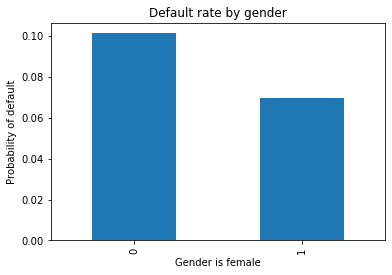

In [17]:
data.groupby('code_gender_f').target.mean().plot(kind='bar')
plt.xlabel('Gender is female'); plt.ylabel('Probability of default'); plt.title('Default rate by gender');

# Resample the dataset

Resample the dataset so there are equal numbers of people who repaid and defaulters who didn't repay, so I don't have to deal with those class imbalances when building models (I'd want to be careful here if I were building a real risk model!). This means the default rate for the whole dataset is now about 0.5.

In [18]:
data_resample = data.copy()

data_0 = data_resample[data_resample.target == 0]
data_1 = data_resample[data_resample.target == 1]

data_0_resample = data_0.sample(len(data_1))
data_resample = data_0_resample.append(data_1)
data_resample.shape

(49650, 169)

In [19]:
len(data_resample[data_resample.target == 1]) / len(data_resample)

0.5

Looks good.

In [20]:
data = data_resample

# Split the dataset into train and test sets

In [21]:
def split_dataset(X: DataFrame, protected_characteristics=None):
    """Split the dataset into train and test sets and remove target and protected characteristics."""

    protected_characteristics = protected_characteristics or []
    y = X.target
    X = X.drop(columns=["target"])

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # Median imputation of missing values
    imputer = SimpleImputer(strategy="median")

    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit on the training data
    imputer.fit(X_train)

    # Transform both training and testing data
    X_train = imputer.transform(X_train)
    X_test = imputer.transform(X_test)

    # Repeat with the scaler
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = DataFrame(X_train, columns=X.columns).reset_index(drop=True)
    X_test = DataFrame(X_test, columns=X.columns).reset_index(drop=True)
    y_train = Series(y_train, name="target").reset_index(drop=True)
    y_test = Series(y_test, name="target").reset_index(drop=True)

    # Pull the protected characteristics out of the datasets and return separately for analysis.
    X_train_protected = X_train[protected_characteristics]
    X_train = X_train.drop(columns=protected_characteristics)
    X_test_protected = X_test[protected_characteristics]
    X_test = X_test.drop(columns=protected_characteristics)

    display_markdown(f"Training data shape: **{X_train.shape}**", raw=True)
    display_markdown(f"Testing data shape: **{X_test.shape}**", raw=True)

    return X_train, X_test, y_train, y_test, X_train_protected, X_test_protected


Define the three cases I'm going to look at in this notebook.
- `USE_PROTECTED_CHARACTERISTIC` &mdash; use gender when training the model and when making predictions
- `NO_PROTECTED_CHARACTERISTIC` &mdash; don't use gender when training 
- `REPLACE_PROTECTED_CHARACTERISTIC` &emdash; use gender when training and replace with mean before making predictions

In [22]:
class ProtectedTreatment(Enum):
    USE_PROTECTED_CHARACTERISTIC = 0
    NO_PROTECTED_CHARACTERISTIC = 1
    REPLACE_PROTECTED_CHARACTERISTIC = 2

In [48]:
def replace_protected_characteristic_with_mean(X_train: DataFrame, X_test: DataFrame) -> (DataFrame, DataFrame):
    X_train_gender_f = X_train[['code_gender_f']].copy().rename(columns={'code_gender_f': 'code_gender_f_original'})
    X_test_gender_f = X_test[['code_gender_f']].copy().rename(columns={'code_gender_f': 'code_gender_f_original'})

    X_train.code_gender_f = X_train.code_gender_f.mean()
    X_test.code_gender_f = X_train.code_gender_f.mean()
    display_markdown(f'Replaced `code_gender_f` with mean of **{X_train.code_gender_f.mean()}**', raw=True)

    return X_train, X_test, X_train_gender_f, X_test_gender_f

In [49]:
def split_dataset_and_build_model(X: DataFrame, protected_characteristics: List[str], case: ProtectedTreatment):
    if case in (ProtectedTreatment.USE_PROTECTED_CHARACTERISTIC, ProtectedTreatment.REPLACE_PROTECTED_CHARACTERISTIC):
        X_train, X_test, y_train, y_test, X_train_protected, X_test_protected = split_dataset(X)
    elif case is ProtectedTreatment.NO_PROTECTED_CHARACTERISTIC:
        X_train, X_test, y_train, y_test, X_train_protected, X_test_protected = split_dataset(X, protected_characteristics)
    
    # For fairness metrics, we want positive to be the good outcome, that the loan that was repaid.
    y_train = 1 - y_train
    y_test = 1 - y_test

    lr = LogisticRegression()
    lr.fit(X_train, y_train)

    if case is ProtectedTreatment.REPLACE_PROTECTED_CHARACTERISTIC:
        # *** Pass gender in to this function ***
        X_train, X_test, X_train_protected, X_test_protected = replace_protected_characteristic_with_mean(X_train, X_test)

    return lr, X_train, X_test, y_train, y_test, X_train_protected, X_test_protected

# Build the model

Choose one of these models to train.

In [62]:
lr, X_train, X_test, y_train, y_test, X_train_protected, X_test_protected = split_dataset_and_build_model(data, protected_characteristics, ProtectedTreatment.USE_PROTECTED_CHARACTERISTIC)

Training data shape: **(37237, 168)**

Testing data shape: **(12413, 168)**

In [36]:
lr, X_train, X_test, y_train, y_test, X_train_protected, X_test_protected = split_dataset_and_build_model(data, protected_characteristics, ProtectedTreatment.NO_PROTECTED_CHARACTERISTIC)

Training data shape: **(37237, 166)**

Testing data shape: **(12413, 166)**

In [50]:
lr, X_train, X_test, y_train, y_test, X_train_protected, X_test_protected = split_dataset_and_build_model(data, protected_characteristics, ProtectedTreatment.REPLACE_PROTECTED_CHARACTERISTIC)

Training data shape: **(37237, 168)**

Testing data shape: **(12413, 168)**

Replaced `code_gender_f` with mean of **0.6228750973495871**

# Performance helper functions

In [63]:
def predict_stats(model, X, y, name, plot_curve=True):
    y_pred = model.predict(X)
    y_score = model.predict_proba(X)[:, 1]

    if plot_curve:
        plot_roc_curve(y_true=y, y_score=y_score, feature_name=name)
        
    classification_report = classification_report_dict(y_true=y, y_pred=y_pred, y_score=y_score, name=name, include_ys=False)
    classification_report['tpr'] = get_tpr(model, X, y)
    classification_report['fpr'] = get_fpr(model, X, y)
    classification_report = DataFrame([classification_report])
    return classification_report

In [64]:
def get_tpr(model, X, y):
    """Get true positive rate."""

    tn, fp, fn, tp = confusion_matrix(y, model.predict(X)).ravel()
    return tp / (tp + fn)

In [65]:
def get_fpr(model, X, y):
    """Get false positive rate."""

    tn, fp, fn, tp = confusion_matrix(y, model.predict(X)).ravel()
    return fp / (fp + tn)

# Model performance

AUC is a common measure for building lending models as it's quite easy to move from that to a risk score for making lending decisions.

The AUC of about 0.67 is not great for a population as prime as this one, but is good enough for this exploration.

,name,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1,support_0,support_1,gini,auc,tpr,fpr
0,Train,0.631528,0.630239,0.62674,0.635008,0.629125,0.632614,18601,18636,0.357385,0.678693,0.635008,0.37326


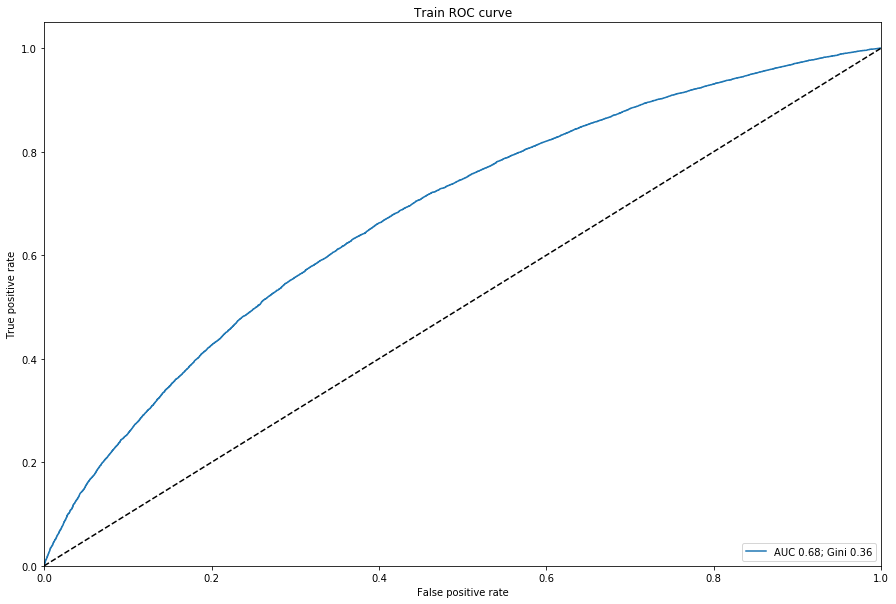

In [66]:
predict_stats(lr, X_train, y_train, name='Train')

,name,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1,support_0,support_1,gini,auc,tpr,fpr
0,Test,0.625725,0.622806,0.623715,0.624818,0.624718,0.62381,6224,6189,0.337849,0.668925,0.624818,0.376285


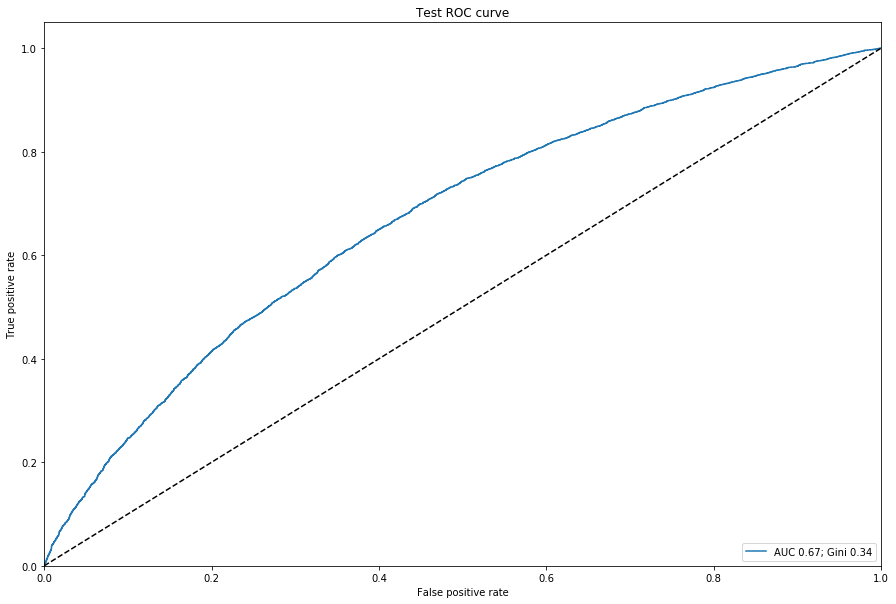

In [67]:
predict_stats(lr, X_test, y_test, name='Test')

In [68]:
def get_fairness(X, X_protected, metric, metric_name, protected_feature, default_class=None, bias_threshold=0.8):
    X = X.copy()
    X = X.join(X_protected)
    X[metric_name] = metric

    bias = DataFrame({metric_name: X.groupby(protected_feature).apply(lambda g: g[metric_name].sum() / len(g))})
    default_class_metric_rate = bias[metric_name].sort_values(ascending=False).iloc[0]
    bias['ratio'] = bias[metric_name] / default_class_metric_rate
    bias[f'meets_{bias_threshold}_threshold'] = bias.ratio >= bias_threshold
    return bias

# Fairness

We can define fairness as ratio of positive predictions for the model for each protected group, here gender. A completely fair model will have the same predicted positive rate for each gender.


# Predictions of a fair model 

$$\ P(\hat{D} = 1|G = m) = P(\hat{D} = 1|G = f)$$

- **G** &ndash; variable for protected class 
- **D** &ndash; model predictions

- Close to disparate impact


The 80% rule can be defined as

$$\ \tau <P(\hat{D}=1|G=m) / P(\hat{D}=1|G=f) < 1 / \tau$$

For a threshold of 80%, we set $$\ \tau = 0.8$$

In [69]:
get_fairness(X_test, X_test_protected, lr.predict(X_test), 'predicted_default_rate', 'code_gender_f')

,predicted_default_rate,ratio,meets_0.8_threshold
code_gender_f,,,
0.0,0.333972,0.5553,False
1.0,0.601426,1.0000,True


This isn't a great test as the default rate for men is higher than women, so the model could reasonably predict men are more likely not to repay the loan.

A couple of metrics that are commonly used for checking fairness and are more useful here are equal opportunity and predictive equality (or FPR, false positive rate, parity).


# Equal opportunity

The TPR (true positive rate) is equal across protected groups

$$\ P(\hat{D} = 1|G = m, D = 1) = P(\hat{D} = 1|G = f, D = 1)$$

For equal opportunity to be true, the TPR should be equal across protected groups, here female and male.

A TP (true positive) is person who did pay back loan and where the model predicted they would. 

A difference TPR unfair because would give fewer opportunities to the minority class. In this case, unusually, the minority class is men. 


# Predictive equality

Or equalized FPR (false positive rate)

FPR is equal across protected groups

$$\ P(\hat{D} = 1|G = m, D = 0) = P(\hat{D} = 1|G = f, D = 0)$$

Here a FP (false positive) is a person who the model said would repay the loan and didn't.

It's similar to equal opportunity, but now I'm trying to equalise FPR across the protected groups.

# Using predictive equality with live lending models

We can use predictive equality with live lending models, unlike predictive equality. If we were actually making lending decisions, we would not have any data on the false negatives (as we wouldn't have lent to them), so we can't so can’t calculate the TPR. 

There are ways around this using reject inference, where we try to estimate if someone we rejected would have repaid, but it relies on quite a lot of assumptions. Another fairly common approach is to accept a small number of people a little below your score cutoff for a period of time, though you'd need to be careful you're lending responsibly!

# Fairness tests

Calculate the ratio between metrics for the protected characteristic, gender. Here I'm interested in the TPR and FPR ratios, and I'm hoping to exceed a ratio of 0.8 from the 80% rule.

In [70]:
def prediction_bias_stats(model, X, X_protected, y, protected_feature):
    X = X.copy()
    X = X.join(X_protected)
    drop_columns = X_protected.columns.tolist() + ['target']
    X['target'] = y

    bias_stats = X.groupby(protected_feature, as_index=False).apply(lambda g: predict_stats(model, g.drop(columns=drop_columns), g.target, name=f'{protected_feature} == {g[protected_feature].iloc[0]}', plot_curve=False))
    display_markdown('## Metrics for protected characteristic', raw=True)
    display(bias_stats)
    display_markdown('## Ratio between class metrics for protected characteristic', raw=True)
    display(bias_stats.iloc[:, 1:].apply(lambda g: g / g.iloc[1]))

Use this cell if gender has not been replaced with the mean when building the model and is in `X_train` or `X_train_protected`.

In [71]:
prediction_bias_stats(lr, X_train, X_train_protected, y_train, 'code_gender_f')

## Metrics for protected characteristic

,,name,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1,support_0,support_1,gini,auc,tpr,fpr
0,0,code_gender_f == 0.0,0.647133,0.606536,0.770072,0.457732,0.703270,0.521731,7959,6163,0.338532,0.669266,0.457732,0.229928
1,0,code_gender_f == 1.0,0.615085,0.638043,0.519545,0.722601,0.563293,0.677695,10642,12473,0.340592,0.670296,0.722601,0.480455


## Ratio between class metrics for protected characteristic

,,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1,support_0,support_1,gini,auc,tpr,fpr
0,0,1.052104,0.950619,1.482203,0.63345,1.248499,0.769862,0.747886,0.494107,0.993953,0.998464,0.63345,0.478564
1,0,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


Use this cell if gender has been replaced with the mean, so we need to get gender from `code_gender_f_original` instead.

In [61]:
prediction_bias_stats(lr, X_train, X_train_protected, y_train, 'code_gender_f_original')

## Metrics for protected characteristic

,,name,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1,support_0,support_1,gini,auc,tpr,fpr
0,0,code_gender_f_original == 0.0,0.67471,0.564948,0.645515,0.596632,0.659790,0.580358,7927,6116,0.339575,0.669787,0.596632,0.354485
1,0,code_gender_f_original == 1.0,0.58859,0.658290,0.605872,0.641948,0.597106,0.650016,10626,12568,0.343604,0.671802,0.641948,0.394128


## Ratio between class metrics for protected characteristic

,,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1,support_0,support_1,gini,auc,tpr,fpr
0,0,1.146315,0.858206,1.065431,0.929409,1.104979,0.892836,0.746,0.486633,0.988273,0.997001,0.929409,0.899416
1,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000000,1.000000


# Which metrics should we use? 

Are equal opportunity and predictive equality a good choice here? 

It depends. I'd try to ask a wider question about the context and use case of our model, the product and our expected demographic. 

For example if we were offering mortgages there's an argument that a FP is likely to be much more severe than a FN: we as the lender would be in line to lose a lot of money, and it's likely that the borrower would lose their home too. It seems much safer to be conservative, and important for fairness that the FPR is no higher for minority classes.

But if we were offering small loans to people who may have difficulty getting access to credit otherwise, then a FN may be more harmful for them as may not have many opportunities to get credit. 

Generally, it's a good idea to look broadly, use multiple fairness metrics and think about what impact it may have on you as a lender and on your customers if your models are biased for that metric.
